# Basic Text Classification with Naive Bayes
***
Audrey Rager<br>
Springboard Data Science Career Track Certificate<br>
September 7, 2020<br>


In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [133]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [134]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


In [135]:
#df[(df['Train'] != 'DeutscheBahn')

#above_35 = titanic[titanic["Age"] > 35]
dfnotfresh = critics[critics['fresh'] != 'fresh']

In [136]:
dfnotfresh.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
30,Roger Ebert,rotten,113497,Chicago Sun-Times,A gloomy special-effects extravaganza filled w...,2000-01-01,12436,Jumanji
37,Derek Adams,rotten,107050,Time Out,"Mediocre, regrettably.",2006-06-24,10498,Grumpy Old Men
40,Roger Ebert,rotten,107050,Chicago Sun-Times,The movie is too pat and practiced to really b...,2000-01-01,10498,Grumpy Old Men
47,Liam Lacey,rotten,114885,Globe and Mail,Never escapes the queasy aura of Melrose Place...,2002-04-12,16697,Waiting to Exhale
49,Edward Guthmann,rotten,114885,San Francisco Chronicle,You want the movie to stomp and rejoice and cr...,2000-01-01,16697,Waiting to Exhale


In [138]:
#print(critics)

### Explore

In [139]:
n_reviews = len(critics)
n_critics = critics.critic.unique().size
n_movies = critics.rtid.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


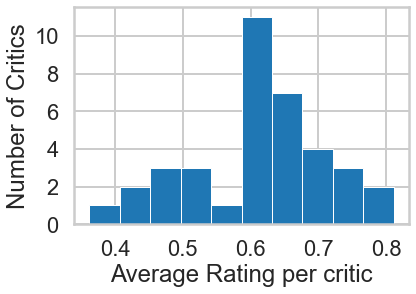

In [140]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

<p><b>Answer:</b> What's being measured here is the proportion of times out of 100 that a given critic rated a movie as "fresh" as opposed to "rotten" (i.e., number of "fresh" ratings given by a critic divided by the total number of reviews given by that critic). The distribution appears to be normal with a left skew or a bimodal distribution with a much lower peak to the left. The mean appears to be about 0.6. This tells me that most critics give most movies very mediocre ratings. The distribution of ratings to the right seems to be a normal distriubtion with a few movies getting ratings of 0.7 or above. There seems to be a longer tail to the right. This means that there are some critics who generally give movies very bad review; but these are more widely spread apart. There are also some critics that generally give movies very good reviews. The two extremes could be due to sampling bias. For example some of the critics may be people who are motivated to post reviews only for very good movies or very bad movies (e.g., bloggers). It could also be an artifact of what movies the critics were assigned by their editors.  Or it could be that the critics in the extremes on both ends are biased. As a movie lover, I would use this information to chose critics from the mean to listen to.  I think these reviewers may tend to be the least biased, assuming that the number of movies that receive a "fresh" rating is normally distributed.
</p>

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,1,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (29,1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 29:trained, 30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [141]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [142]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [143]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

1. split the data set into a training and test set<br>
2. Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.<br>
3. train the classifier over the training set and test on the test set<br>
4. print the accuracy scores for both the training and the test sets.<br>
5. What do you notice? Is this a good classifier? If not, why not?
</div>

In [144]:
#Import the classifier and the train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

#Split the data (X) into train and test sets.
train_X, test_X, train_y, test_y = train_test_split(X,y, random_state=42)



<div class="span5 alert alert-info">
<h3>Exercise Set II - Continued</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>


2. Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.

</div>

In [145]:
#Instantiate the classifier and fit it on the training data set
clf = MultinomialNB()


<div class="span5 alert alert-info">
<h3>Exercise Set II - Continued</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

3. train the classifier over the training set and test on the test set<br>

</div>

In [146]:
clf.fit(train_X, train_y)
print("MN Accuracy: %0.2f%%" % (100 * clf.score(test_X, test_y)))


MN Accuracy: 77.82%


<div class="span5 alert alert-info">
<h3>Exercise Set II - Continued</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

4. print the accuracy scores for both the training and the test sets.<br>

</div>

In [147]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#Calculate accuracy score using the training and test data
print("Training set accuracy score: " + str(round(clf.score(train_X, train_y),2)))
print("Testing set accuracy score: " + str(round(clf.score(test_X,test_y),2)))
predicted = clf.predict(test_X)
print("\nMean prediction accuracy is: ", np.mean(predicted == test_y))
print("\n\nClassification report:\n", classification_report(test_y, predicted))
print("\n\nConfusion matrix:\n", confusion_matrix(test_y, predicted))

Training set accuracy score: 0.92
Testing set accuracy score: 0.78

Mean prediction accuracy is:  0.7782061166795168


Classification report:
               precision    recall  f1-score   support

           0       0.74      0.64      0.69      1497
           1       0.79      0.86      0.83      2394

    accuracy                           0.78      3891
   macro avg       0.77      0.75      0.76      3891
weighted avg       0.78      0.78      0.77      3891



Confusion matrix:
 [[ 964  533]
 [ 330 2064]]


<div class="span5 alert alert-info">
<h3>Exercise Set II - Continued</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

5. What do you notice? Is this a good classifier? If not, why not?
</div>

<p><b>Answer: </b> The first thing that stands out is the large difference between the training set accuracy score (0.92) and the testing set accuracy score (0.78). I don't think this is a good classifier because of this discrepancy.  This classifier is only going to predict whether a movie is rated "fresh" or "rotten" about 78% of the time. I think this classifier is overitting the data. We can do better.
   </p>

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise a:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>
</div>

In [148]:
type(X)

scipy.sparse.csc.csc_matrix

In [149]:
#Construct the cumulative distribution of document frequencies (df). 

#For each word, count the number of unique documents that contain it
#and put in an empty list
count = (X>0).sum(axis=0).tolist()[0]
#sort the list from low to high count
count = sorted(count)


In [150]:
#Construct the cumulative distribution of document frequencies (df). 
#Continued

#Compute count of unique words in unique docments
n = np.unique(count)
#print(n)

<function matplotlib.pyplot.show(close=None, block=None)>

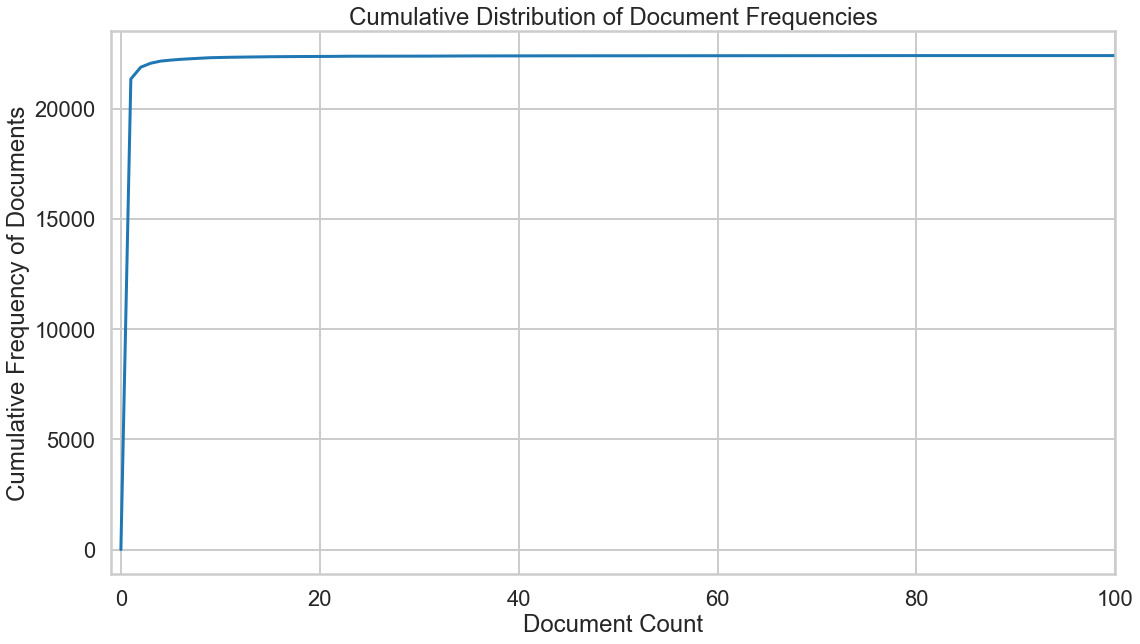

In [151]:
#Construct the cumulative distribution of document frequencies (df). 
#Continued

#Compute the frequency of words that appear in k documents
freq, cat = np.histogram(count, bins = len(n)) #unpacking count of each word
                                               #and lenght
cumfreq = np.cumsum(freq)
cumfreq = np.insert(cumfreq,0,0)
n = np.insert(n,0,0)

#Create the Plot
plt.figure(figsize=(18,10))
plt.plot(n,cumfreq)
plt.xlim(-1,100)
plt.xlabel('Document Count')
plt.ylabel('Cumulative Frequency of Documents')
plt.title('Cumulative Distribution of Document Frequencies')
plt.show





<function matplotlib.pyplot.show(close=None, block=None)>

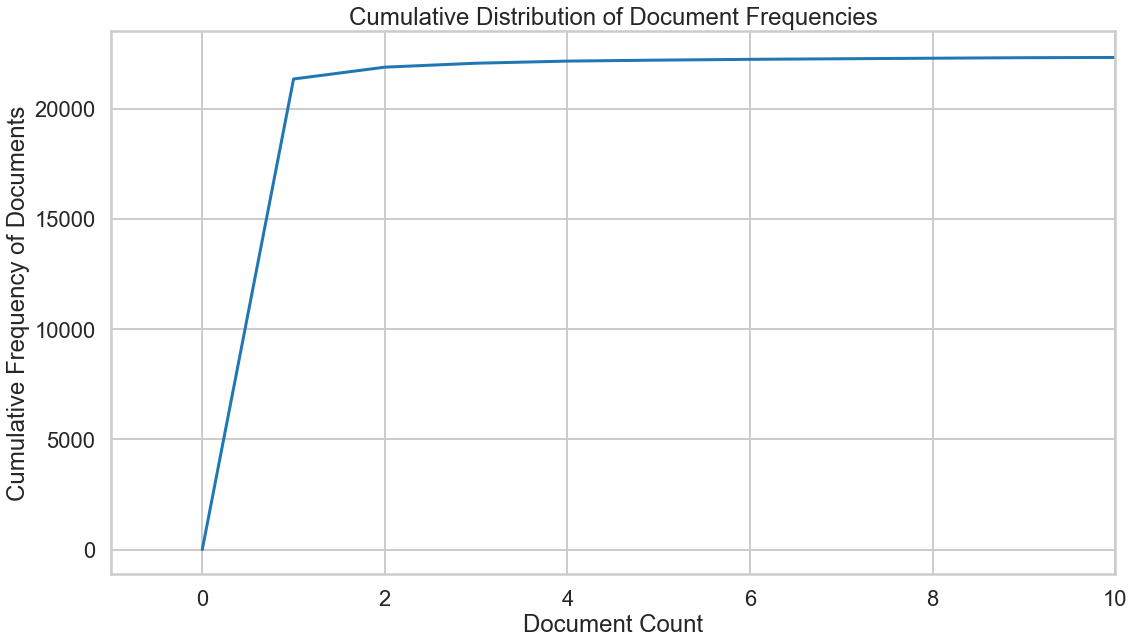

In [152]:
#Plotting it again to zoom in to where the steep curve levels off
plt.figure(figsize=(18,10))
plt.plot(n,cumfreq)
plt.xlim(-1,10)
plt.xlabel('Document Count')
plt.ylabel('Cumulative Frequency of Documents')
plt.title('Cumulative Distribution of Document Frequencies')
plt.show

<div class="span5 alert alert-info">
<h3>Exercise Set III - Continued</h3>


<p><b>Exercise b:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

<p><b>Answer b:</b> I would chose a value of 1 for min_df.  For max_df, I choose 5. That seems to be where it has leveled off.</p>

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [153]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [154]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [155]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise a:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

</div>

<p><b>Answer a:</b> The likelihod function gives the probability of the observed data under the model. It tells us how plausible the model is given the data that we have. Many numbers between 0 and 1 are multiplied to calculate likelihood, making the result a very small number.  A score for naive bayes is the sum of the log prior and log liklihood. We are trying to optimize for the parameters that maximize the probability of correctly predicting training data. </p>

<div class="span5 alert alert-info">
<h3>Exercise Set IV - Continued</h3>

<p><b>Exercise b:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

</div>

<p><b>Answer b:</b> Increasing $\alpha$ will reduce the variance of the model through excessive smoothing and therefore increase the bias.</p>

<div class="span5 alert alert-info">
<h3>Exercise Set IV - Continues</h3>

<p><b>Exercise c:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

In [156]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [0.1, 1, 5, 10, 50]
min_dfs = [0.00001, 0.0001, 0.001, 0.01, 0.1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf
for alpha in alphas: 
    for min_df in min_dfs:
        vectorizer = CountVectorizer(min_df=min_df)       
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        # Cross validate the NB model and compute a log likelihoood score
        clf = MultinomialNB(alpha=alpha)
        score = cv_score(clf, Xtrainthis, ytrainthis, scorefunc=log_likelihood)
        if score > maxscore:
            maxscore = score
            best_alpha = alpha
            best_min_df = min_df
#print(alpha, best_min_df, maxscore)

In [157]:
print("Best alpha: {}\nBest min_df: {}\nMax Score: {}".format(best_alpha, best_min_df, maxscore))

Best alpha: 5
Best min_df: 0.001
Max Score: -570.9440351038147


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [158]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.803384
Accuracy on test data:     0.720988


In [159]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[2039 2204]
 [ 835 5814]]


## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [160]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
         masterpiece 0.87
       entertainment 0.85
                rare 0.84
        entertaining 0.83
         intelligent 0.83
         achievement 0.83
           hitchcock 0.83
           wonderful 0.82
            american 0.82
              visual 0.81
Bad words	     P(fresh | word)
                dull 0.30
               bland 0.29
          uninspired 0.28
             problem 0.26
       unfortunately 0.26
                ugly 0.26
      disappointment 0.26
               fails 0.26
                lame 0.24
           pointless 0.24


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

<p><b>Answer:</b> The method works because it has trained on a training data set with many words associated with either a "fresh" or "rotten" rating. The probability associated with each word in each row represents the probability that the movie has a "fresh" rating.
</p>

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [161]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
It survives today only as an unusually pure example of a typical 50s art-film strategy: the attempt to make the most modern and most popular of art forms acceptable to the intelligentsia by forcing it into an arcane, antique mold.

Though based on an original and respected novel, Hyams' horror thriller comes across as a pastiche of the genre's conventions as evident in major pictures of the past two decades, such as Jaws and the first two Alien films.

Despite great scenery, the distinctive visual ideas of Mr. Scott (Alien, Blade Runner) and the strong dramatic presence of Mr. Bridges, most of White Squall remains listless and tame.

Voight's performance gives credibility to his character's obsession, but even that cannot overcome the discrepancy between the deeper themes and the routine nature of this piece of box-office action adventure.

Part comedy, part family drama, part romance, part special-effects mystery-adventure, and n

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*

</ul>
</div>
</div>

In [162]:
#your turn

myQuote = 'This movie is not remarkable, touching, or superb in any way'
myText = vectorizer.transform([myQuote])
clf.predict_proba(myText)

array([[0.04862504, 0.95137496]])

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review - Continued</h3>
<br/>
<b>Exercise:</b>
<ul>
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

</div>

<p><b>Answer:</b> Reading the review, it's obvious that the reviewer did not like it and it should be classfied as "rotten." The score is very high (0.95), perhaps because there were three positive words in one sentence.However, looking at the words in the quote, I'm not suprised.  The quote contains the words "remarkable", "toucing", and "superb."  The  model has not been trained to look for the word "not" in front of each adjective, let alone one "not" that applies to a string of three adjectives. 
</p>

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [164]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment <b>(Optional)</b></h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try at least one of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result. 
</div>

In [ ]:
# Your turn